In [1]:
import requests as rq 
import json 
import string as alphabet 
import os 


<h2>The first part is about the data structure used to compute the caloric intake of a given recipe</h2>

In [2]:
# global variables
recipes_folder       = os.path.join("data_recipes", "recipes_alphabetical_order")



The following function is used to save all recipes in a local folder (defined by recipes_folder) for convenience. This will ensure that there will no longer be a need of any Internet connection. 


In [3]:
def download_recipes(folder):
    for letter in alphabet_letter_list: 
        json_recipes = rq.get(f"https://www.themealdb.com/api/json/v1/1/search.php?f={letter}").json()

        with open(folder, "w") as f:
            json.dump(json_recipes, f)
            

In [4]:
# check if the data are already downloaded. If yes, do nothing.
if os.path.exists(recipes_folder):
    if len(os.listdir(recipes_folder)) == 0:
        download_recipes(recipes_folder)
        print(f"The recipe data has been successfully downloaded and can be found under the location {recipes_folder}")
    else:
        print("The recipe data has been already downloaded")
        pass
else:
    download_recipes(recipes_folder)
    print(f"The recipe data has been successfully downloaded and can be found under the location {recipes_folder}")

The recipe data has been already downloaded


In [5]:
class Data():
    alphabet_letter_list = list(alphabet.ascii_lowercase)
    '''
    The self._recipes_data variable is structured as follows:

    self._recipes_data = {
                            "recipe_0": { "ingredient_0" : {"amount": amount_0,  "calories_100g": calories_0, "nam  },   
                                          "ingredient_1" : {"amount": amount_1,  "calories_100g": calories_1  },
                                          ...,

                                          "ingredient_20": {"amount": amount_20, "calories_100g": calories_20 }   
                                        },

                            "recipe_1": { "ingredient_0" : {"amount": amount_0,  "calories_100g": calories_0  },
                                          "ingredient_1" : {"amount": amount_1,  "calories_100g": calories_1  },
                                          ...,

                                          "ingredient_20": {"amount": amount_20, "calories_100g": calories_20 }   
                                        },
                            ...,

                            "recipe_N": { "ingredient_0" : {"amount": amount_0,  "calories_100g": calories_0  },
                                          "ingredient_1" : {"amount": amount_1,  "calories_100g": calories_1  },
                                          ...,

                                          "ingredient_20": {"amount": amount_20, "calories_100g": calories_20 }   
                                        },

                          }                   
    '''
    def __init__(self):
        '''
            The objective of the constructor of this class is to fill the data structure as shown above. 
            To do this, the previously downloaded data and other auxiliary data that were derived manually 
            are used, namely the weight in grams of each ingredient and their respective calories per 100g.
            (The calories and weight should be revised perhaps, but for an initial 
            prototype/proof of concept this should work)
        '''
        self._recipes_data = {}
        
        map_strIngredient_2_kcal100g = {}
        with open(os.path.join("data_recipes", "strIngredient_kcal100g.txt"), 'r') as f:
            '''
                The data in strIngredient_kcal100g.txt are saved in this format:
                    [strIngredient] : [calories/100g]kcal
                    
                    Example: 
                        Butter: 717kcal
                        Tomato Puree: 32kcal
                        Brie: 334kcal
                        Sea Salt: 0kcal
                        Egg: 143kcal
                        ...
            '''
            lines = f.readlines()

            for line in lines:
                # split line
                parts = line.split(':')
                # remove spaces
                ingredient = parts[0].strip()
                # remove unit of measure
                kcal  = parts[1].strip().replace("kcal", "")
                # save value
                map_strIngredient_2_kcal100g[ingredient.lower()] = kcal

        map_strMeasure_strIngredient_2_weight = {}
        with open(os.path.join("data_recipes", "strMeasure_strIngredient_weight.txt"), 'r') as f:
            '''
                The data in strMeasure_strIngredient_weight.txt are saved in this format:
                    [strMeasure] : [strIngredient] : [weight]g
                    
                    Example: 
                        175g : digestive biscuits : 175g
                        75g : butter : 75g
                        1/2 lb: Beef: 225g
                        1 tsp : almond extract: 5g
                        ...
                        
                Note:
                    Some of the weights are assumption. Some examples:
                        - 1 egg is assumed to be 50g.
                        - 1 tsp (teaspoon) is assumed to be 5g. 
                        - 1 cup is assumed to be 100g
                        ...
            '''
            lines = f.readlines()

            for line in lines:
                parts = line.split(':')
                measure, ingredient, weight_in_gram = [part.strip() for part in parts]
                map_strMeasure_strIngredient_2_weight[(ingredient.lower(), measure.lower())] = weight_in_gram.replace("g", "")
        
        # iterate through all the recipes in alphabetical order
        for letter in self.alphabet_letter_list:
            json_filename = os.path.join("data_recipes", "recipes_alphabetical_order", f"{letter}.json")

            json_data = None
            with open(json_filename, 'r') as f:
                json_data = json.load(f)
            
            # build data structure as explained before
            if json_data and json_data["meals"]:
                # iterate through all recipes
                for recipe in json_data["meals"]:
                    ingredient_dict = {}
                    for n in range(20):
                        ingredient_name   = recipe[f"strIngredient{n+1}"]
                        ingredient_amount = recipe[f"strMeasure{n+1}"]

                        if (ingredient_name!="" and ingredient_amount!="") and (ingredient_name!=None and ingredient_amount!=None):
                            ingredient_amount = ingredient_amount.lower()
                            ingredient_name = ingredient_name.lower()

                            if (ingredient_name, ingredient_amount) in map_strMeasure_strIngredient_2_weight and \
                                ingredient_name in map_strIngredient_2_kcal100g:

                                amount = map_strMeasure_strIngredient_2_weight[(ingredient_name, ingredient_amount)]
                                kcal   = map_strIngredient_2_kcal100g[ingredient_name]

                                try:
                                    ingredient_dict[f"ingredient_{n}"] = { "amount"        : float(amount), 
                                                                           "calories_100g" : float(kcal),
                                                                           "name"          : ingredient_name }
                                except:
                                    ingredient_dict[f"ingredient_{n}"] = { "amount"        : None, 
                                                                           "calories_100g" : None,
                                                                           "name"          : ingredient_name}
                            else:
                                ingredient_dict[f"ingredient_{n}"] = { "amount"        : None, 
                                                                       "calories_100g" : None,
                                                                       "name"          : ingredient_name}

                        else:
                            ingredient_dict[f"ingredient_{n}"] = { "amount"        : None, 
                                                                   "calories_100g" : None,
                                                                   "name"          : ingredient_name}

                    self._recipes_data[recipe["strMeal"]] = ingredient_dict 
                    
    def get_recipe(self, recipe_name):
        return self._recipes_data[recipe_name]
    
    def get_ingredient_list(self, recipe_name):
        recipe = self._recipes_data[recipe_name]
        ingredient_list = []
        
        for n in range(20):
            if recipe[f"ingredient_{n}"]["amount"] != None and\
               recipe[f"ingredient_{n}"]["calories_100g"] != None:
                ingredient_list.append(recipe[f"ingredient_{n}"]["name"])
            else:
                ingredient_list.append("NaN")
                       
            
        return ingredient_list
    
    def get_recipe_list(self):
        return list(self._recipes_data.keys())
                

In [6]:
# create the data Object
data = Data()

In [7]:
# example of an ingredient
recipe = data.get_recipe("Fish pie")
recipe["ingredient_0"]

{'amount': 900.0, 'calories_100g': 77.0, 'name': 'floury potatoes'}

In [8]:
# how to get a list of ingredient from a given recipe
data.get_ingredient_list("Fish pie")

['floury potatoes',
 'olive oil',
 'semi-skimmed milk',
 'white fish fillets',
 'plain flour',
 'nutmeg',
 'double cream',
 'jerusalem artichokes',
 'leek',
 'prawns',
 'parsley',
 'dill',
 'lemon',
 'gruyère',
 'lemon',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN']

In [9]:
# how to get a list of all recipes
data.get_recipe_list()

['Apple Frangipan Tart',
 'Apple & Blackberry Crumble',
 'Apam balik',
 'Ayam Percik',
 'Bakewell tart',
 'Bread and Butter Pudding',
 'Beef Wellington',
 'Baingan Bharta',
 'Beef Brisket Pot Roast',
 'Beef Sunday Roast',
 'Braised Beef Chilli',
 'Beef stroganoff',
 'Broccoli & Stilton soup',
 'Bean & Sausage Hotpot',
 'Banana Pancakes',
 'Beef Dumpling Stew',
 'Beef and Mustard Pie',
 'Beef and Oyster pie',
 'Blackberry Fool',
 'Battenberg Cake',
 'Beef Bourguignon',
 'Brie wrapped in prosciutto & brioche',
 'Boulangère Potatoes',
 'BeaverTails',
 'Brown Stew Chicken',
 'Beef Lo Mein',
 'Baked salmon with fennel & tomatoes',
 'Budino Di Ricotta',
 'Breakfast Potatoes',
 'Bitterballen (Dutch meatballs)',
 'BBQ Pork Sloppy Joes',
 'Beef Banh Mi Bowls with Sriracha Mayo, Carrot & Pickled Cucumber',
 'Big Mac',
 'Bigos (Hunters Stew)',
 'Boxty Breakfast',
 'Beef Rendang',
 'Burek',
 'Beef Mechado',
 'Bistek',
 'Beef Caldereta',
 'Beef Asado',
 'Bread omelette',
 'Beetroot Soup (Borscht)',




<h2>The second part is about finding a valid recipe, given a list of ingredients</h2>


In [10]:
from PIL import Image
import urllib.request
import io

In [11]:
#This code imports the .json file of all recipes from TheMealDB (#1), reformats it into a recipe list (#2),
# makes a list of recipe names (#3), and a dictionary with each recipe and its ingredients (#4).
# You can print the intermediate results at each step to see what it does.

#1
allrecipesdictionary = {}
for letter in list(alphabet.ascii_lowercase): #for loop for each letter in the alphabet
    letterresult = rq.get(f"https://www.themealdb.com/api/json/v1/1/search.php?f={letter}").json()
    #normal http request function that imports a json file with all recipes starting with a given letter, for all letters
    #TheMealDB is structured per letter, so we need to repeat this request 26 times in a for loop.
    allrecipesdictionary[letter] = letterresult
    #this function, repeated in the for loop, joins all results in a single dictionary, allrecipesdictionary.

#print(allrecipesdictionary['a']['meals'])
#As you can see if you print, this dictionary is still complex.


#2
reformatted_allrecipeslist = []    
for letter in list(alphabet.ascii_lowercase):
    if allrecipesdictionary[letter]['meals']:
    #this is a quick if function that excludes empty items. We have no recipes starting with x, for example.
        all_recipes_letter = allrecipesdictionary[letter]['meals']
        reformatted_allrecipeslist += all_recipes_letter

#This reformatted_allrecipeslist is a list with each of its items being a dictionary containing all info on a given recipe.
#print(reformatted_allrecipeslist)

recipenamelist = []
for recipeindex in range(len(reformatted_allrecipeslist)-1):
    recipenamelist.append(str(reformatted_allrecipeslist[recipeindex]['strMeal']))

#This is a list of fhe names of all the recipes we have at our disposal. Maybe it will be useful.
#print(recipenamelist)

recipedict_withingredients = {}
for recipedescription in reformatted_allrecipeslist:
    recipeingredients = []
    for number in range(1,20): #in the API, a recipe has a maximum of 20 ingredients. They are stored in 20 values.
        ingredientnumber = "strIngredient" + f'{number}'
        recipeingredients.append(recipedescription[ingredientnumber])
    recipedict_withingredients[recipedescription['strMeal']] = recipeingredients

#This is a dictionary of all recipes with their respective ingredients. You can print it below.
#for recipename in recipedict_withingredients:
    #print(f'{recipename}: {recipedict_withingredients[recipename]}\n')



def recipesearch (chosen_ingredients_list = [], recipedict_withingredients = {}):
    
    #This function takes a list of ingredients and returns the 5 recipes in the TheMealDB database
    #that contain the most of these ingredients
    
    #This part of the function defines a dictionary with each recipe name and 
    #its corresponding similarity score to the chosen ingredients list.
    
    recipedict_withscores = {}
    for recipename, recipe_ingredients_list in recipedict_withingredients.items():
        for recipe_ingredient in set(recipe_ingredients_list):
            #set because some TheMealDB recipes contain duplicate ingredients
            if recipe_ingredient in chosen_ingredients_list:
                if recipedict_withscores.get(recipename) == None:
                       recipedict_withscores[recipename] = 1
                else: recipedict_withscores[recipename] += 1
                    
    #This part of the function defines a dictionary with the top five recipes and 
    #their corresponding similarity scores to the chosen ingredients list.                  
    
    recipes_result = {}
    recipe_results_length = 0
    for diminishing_similarity_coefficient in range(3):
        for recipestr, recipescore in recipedict_withscores.items():
            if recipe_results_length < 5:
                if recipescore == (len(chosen_ingredients_list) - diminishing_similarity_coefficient):
                        recipes_result[recipestr] = recipescore
                        recipe_results_length += 1
            
    return recipes_result

from PIL import Image
import urllib.request
import io

class Chosen_Meal:
    
    def __init__ (self, mealname):
        self.mealname = str(mealname)
        self.fullrecipe = rq.get("https://www.themealdb.com/api/json/v1/1/search.php?s="+str(mealname)).json()["meals"][0]
        self.recipetext = self.fullrecipe["strInstructions"]
        
        self.ingredientswithquantities = {}
        for numbertotwenty in range(1, 21):
            self.ingredientswithquantities[self.fullrecipe["strIngredient"+str(numbertotwenty)]] = f'{str(self.fullrecipe["strMeasure"+str(numbertotwenty)])}'
        
        self.ingredients_text = ""
        for ingredient, quantity in self.ingredientswithquantities.items():
            if ingredient:
                self.ingredients_text += f'{ingredient}: {quantity}\n'
               

    
    def __str__ (self):
        return f'''{self.mealname}:\n\n
    Ingredients:\n
    {self.ingredients_text}\n
    {self.recipetext}'''
    
    def photo(self, ax):
        image_URL = self.fullrecipe["strMealThumb"]
        with urllib.request.urlopen(image_URL) as url:
            f = io.BytesIO(url.read())
        img = Image.open (f)
        
        ax.imshow(img)
        ax.set_title(self.fullrecipe["strMeal"])
    

In [12]:
import matplotlib.pyplot as plt

def get_output_from_chosen_ingredients(ingredients):
    chosen_recipeslist = list(recipesearch(ingredients, recipedict_withingredients).keys())[:-1]
    
    
    recipeobjectslist = []
    for localindex in range(4):
        recipeobjectslist.append(Chosen_Meal(chosen_recipeslist[localindex]))
        
    fig,axs = plt.subplots(len(chosen_recipeslist),2, figsize=(20,20))

    for n,recipeobject in enumerate(recipeobjectslist): 
        recipeobject.photo(axs[n,0])

        recipe_name = recipeobject.mealname

        ingredients = data.get_recipe(recipe_name)

        sum_kcal = 0
        idx = 0
        idx_name_list = []
        for i in range(20):
            ingredient = ingredients[f"ingredient_{i}"]


            kcal = ingredient["calories_100g"]
            amount = ingredient["amount"]

            if kcal == None or amount == None:
                continue
            kcal = amount*kcal/100.0

            sum_kcal += kcal

            axs[n,1].bar(idx, kcal, color = "green")
            idx_name_list.append(f"{ingredient['name']}\n{amount}g")
            idx += 1

        idx_sum = idx+2
        axs[n,1].bar(idx_sum, sum_kcal)
        axs[n,1].set_xticks(list(range(len(idx_name_list)))+[idx_sum],idx_name_list+["Total calories"], fontsize=13, rotation=80)
        axs[n,1].set_ylabel('Calories (kcal)', fontsize=15)
        axs[n,1].grid()

    fig.tight_layout()

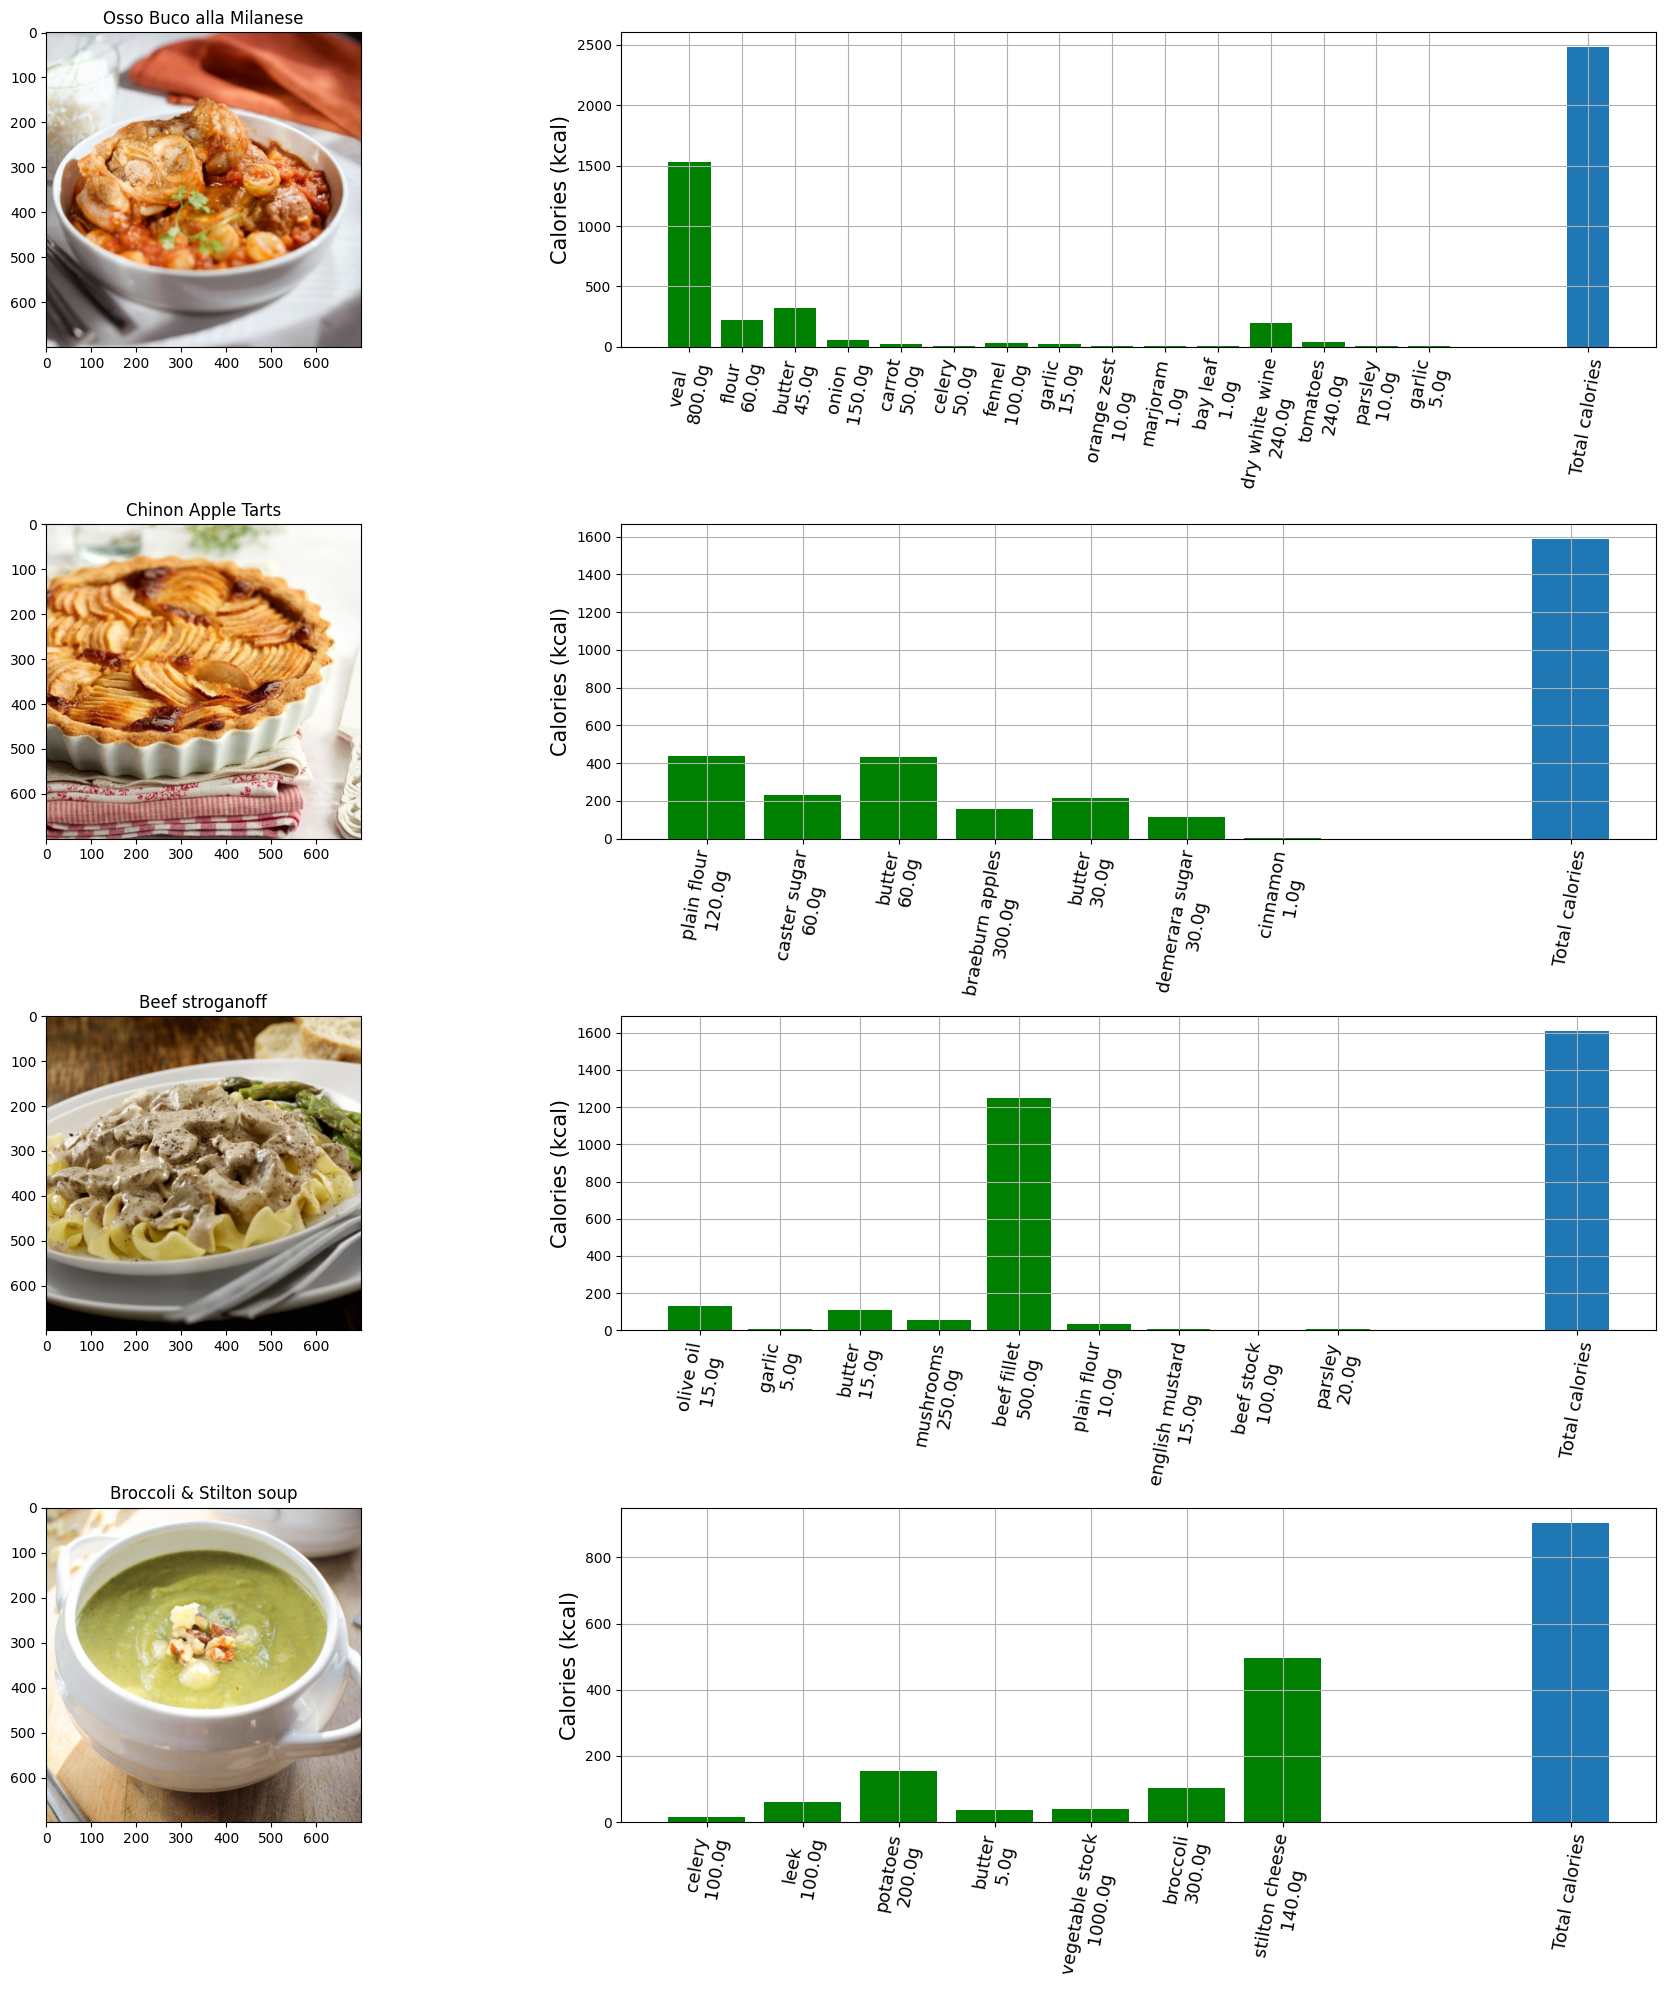

In [13]:
'''
    Here you can choose a list of ingredients and the program will check the possible recipes.
'''
ingredientslist = ["Veal", "Basil Leaves", "Butter"]

'''
    NOTE: 
            It's possible that some calorie intake plots may have fewer ingredients than those 
            listed in the database. I haven't checked all of them, but it's also possible that 
            some recipes have no ingredients at all. This could be due to one or both of the 
            following reasons:

            1. Some data related to the calories of various foods couldn't be found.
            2. It wasn't possible to convert the strMeasure string (which indicates 
               the amount of each ingredient) into grams.
'''

get_output_from_chosen_ingredients(ingredientslist)